# 0. Load dependencies and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import *
import warnings
from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


task_colors = {'perception': 'teal', 'wm': 'green', 'ltm': 'orange'}


warnings.filterwarnings('ignore')
wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]
roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

# Set path to dataframe directory
df_dir = "../../data/dataframes/"

Load the vonmises fits and bootstrapped confidence intervals from both studies. Also, initialize some custom values for plotting aesthetics.

In [7]:
VM = pd.read_csv(os.path.join(df_dir, "interstellar_robserra_ROIlevel_comparison.tsv"), sep = '\t')

within_roi_gap = 0.2
group_indices = {
    'serra_perception' : 2 * within_roi_gap,
    'rob_perception': 3 * within_roi_gap,
    'serra_ltm': 0 * within_roi_gap,
    'rob_ltm' : 1 * within_roi_gap,
    'rob_near': 2 *within_roi_gap,
    'rob_far': 3 * within_roi_gap
}

roi_gap = 1.5



Load the estimates and bootrapped data for each group (near, far). Concatenate them appropriately.

In [4]:
group = 'nearest_dist_bin'
keys = ['near', 'far']
tasks = ['perception', 'wm', 'ltm']

P, B = [], []

for key in keys:
    params_fname = "interstellar_%s-all_%s_params.tsv" % (group, key)
    boots_fname = "interstellar_%s-all_%s_boot_params.tsv" % (group, key)

    p = pd.read_csv(os.path.join(df_dir, params_fname), sep = "\t", index_col = 0)
    b = pd.read_csv(os.path.join(df_dir, boots_fname), sep = "\t", index_col = 0)
    p[group] = key
    b[group] = key
    
    P.append(p)
    B.append(b)

P = pd.concat(P)
B = pd.concat(B)

B['roi_labels'] = [roi_labels[int(l-1)] for l in B.roi.values]
P['roi_labels'] = [roi_labels[int(l-1)] for l in P.roi.values]

# 1. Figure 7a
- Plot the second panel first, this shows the near vs far tuning with estimates. 
- Plot the 68% confidence intervals for the near & far groups.
- Plot on top the mean tuning width estimates for both studies
- Plot the first panel second, showing the perception and long-term memory tuning width estimates across the visual hierarchy. And their 68% and 95% bootstrapped confidence intervals.

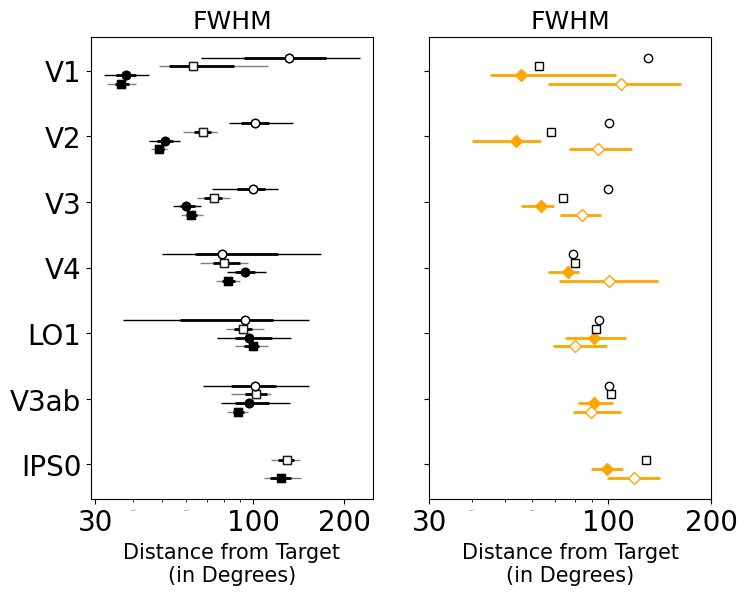

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (8, 6), sharey = True)
task = 'ltm'
val = 'fwhm'
group_var = 'nearest_dist_bin'
metric = 'fwhm'

lims = {
    'loc': [-30, 30],
    'amp': [0, 2],
    'fwhm': [30, 200]
}

data = P.query("task == @task")
fc = 'black'
stask_colors = {'perception': 'darkslategray', 'ltm': 'darkorange'}

for group in data[group_var].unique():
    ax = axes[1]
    data_group = data.query("nearest_dist_bin == @group")

    y = []
    for label in data_group.roi_labels:
        y_pos = rois.index(label)*(roi_gap) + group_indices['rob_%s' % group]
        y.append(y_pos)

    # Boot fits
    bfits = []
    for roi in data_group.roi_labels:
        boot_metric = B.query('task == @task & nearest_dist_bin == @group & roi_labels == @roi')[metric]
        bfits.append(boot_metric)
    bfits=np.vstack(bfits)
    err_bands1 = np.nanpercentile(bfits, [16, 84], axis=1)
    err_bands2 = np.nanpercentile(bfits, [2.5, 97.5], axis=1)

    lower1, upper1 = err_bands1[0, :], err_bands1[1, :]
    lower2, upper2 = err_bands2[0, :], err_bands2[1, :]

    x = data_group[metric]

    if list(data[group_var].unique()).index(group): 
        ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = task_colors[task], fmt = 'o', alpha = 1, ms = 6, marker = 'D', markerfacecolor = 'white', label = group)
    else:
        ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 2, c = task_colors[task], fmt = 'o', alpha = 1, ms = 6, marker = 'D', label = group)
   



    ax.set_xlim(lims[metric])
    

    ax.set_xscale('log')
    ax.set_xticks([30, 100, 200])
    ax.set_xticklabels([30, 100, 200])
    ax.set_title('FWHM', size = 18)
    ax.set_xlabel("Distance from Target\n(in Degrees)", size = 15)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=0)

axes[0].invert_yaxis()


data_rob = VM.query("experimenter == 'rob'")
data_serra = VM.query("experimenter == 'serra'")

tasks = ['perception', 'ltm']
metric = 'fwhm'


for task in tasks:
    data_r = data_rob.query("task == @task & param == @metric")
    data_s = data_serra.query("task == @task & param == @metric")

    ax = axes[0]

    y_r = []
    for label in data_r.roi:
        y_pos = rois.index(label)*(roi_gap) + group_indices['rob_%s' % task]
        y_r.append(y_pos)

    y_s = []
    for label in data_s.roi:
        y_pos = rois.index(label)*(roi_gap) + group_indices['serra_%s' % task]
        y_s.append(y_pos)
        
    if task == 'ltm':
        mfc = 'white'
    else:
        mfc = 'black'


    ax.errorbar(data_r.value, y_r, xerr = [data_r.value - data_r['68_ci_lower'], data_r['68_ci_upper'] - data_r.value], elinewidth = 2, c = 'black', fmt = 'o', alpha = 1, ms= 6, markerfacecolor = mfc, marker = 's')
    ax.errorbar(data_r.value, y_r, xerr = [data_r.value - data_r['95_ci_lower'], data_r['95_ci_upper'] - data_r.value], elinewidth = 1, c = 'black', fmt = 'o', alpha  = 0.5, ms = 6, markerfacecolor = mfc, marker = 's')
    ax.errorbar(data_s.value, y_s, xerr = [data_s.value - data_s['68_ci_lower'], data_s['68_ci_upper'] - data_s.value], elinewidth = 2, c = 'black', fmt = 'o', alpha = 1, marker = "o", ms = 6, markerfacecolor = mfc)
    ax.errorbar(data_s.value, y_s, xerr = [data_s.value - data_s['95_ci_lower'], data_s['95_ci_upper'] - data_s.value], elinewidth = 1, c = 'black', fmt = 'o', alpha  = 1, marker = "o", ms = 6, markerfacecolor = mfc)

    ax.set_yticks((np.asarray([1, 2, 3, 4, 5, 6, 7]) - 1)* roi_gap  + 1.5*within_roi_gap)
    ax.set_yticklabels(rois)



    ax.set_xscale('log')
    ax.set_xticks([30, 100, 200])
    ax.set_xticklabels([30, 100, 200])
    ax.set_title("FWHM", size = 18)
    ax.set_xlabel("Distance from Target\n(in Degrees)", size = 15)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=0)


    ax = axes[1]
    if task == 'ltm':
        ax.errorbar(data_s.value, y_s, xerr = 0, elinewidth = 1, c = 'black', fmt = 'o', alpha  = 1, marker = "o", ms = 6, markerfacecolor = 'white')
        ax.errorbar(data_r.value, y_r, xerr = 0, elinewidth = 1, c = 'black', fmt = 'o', alpha  = 1, marker = "s", ms = 6, markerfacecolor = 'white')